# Лабораторная работа № 4. Латентное размещение Дирихле

In [19]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [2]:
rawdata = pd.read_csv("wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [3]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

A young homeless girl, Ha-dam, moves to Busan in the hopes of finding work, only to be rebuffed at every turn. 

Manson Lo, the head broker of Man Sang Securities is shown giving his prediction of the Hong Kong stock market on television. Through the viewpoint of an eavesdropper, it is revealed that Lo works for five of the richest in Hong Kong to manipulate the prices of shares in the stock market. When leaving his office, he realizes that he is being tailed (by Joe Sze-ma) and though successful in shaking off the tail, is involved in a traffic accident.
Inspector Ho and his team discover a military grade eavesdropping device upon examining Lo’s Ferrari. Ho later visits Lo in hospital and attempts to ask him questions but Lo denies knowledge of being followed and evades the other questions at the advice of Emily, his wife and lawyer. Lo’s past is revealed by Ho – Lo’s firm owed the bank money but because of the stock market crash, Lo instead made a lot of money and then became the bro

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [4]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [7]:
print(data.sample(1).values[0])

a young girl who is unable to sleep asks her father to tell her a bedtime story although reluctant at first he tell her a story of a fly named nani nani is a young man who specialises in preparing firework he is in love with his neighbour bindu a micro artist who run project a organisation ngo bindu also develops feeling for nani though she doe not express them seeking to raise money for her ngo bindu visit the office of a rich powerful industrialist named sudeep who also find her attractive he befriends her donates million u thousand and gain her trust sudeep see nani a a rival and plan to kill him one night nani help bindu to finish a piece of micro locket made from a pencil while returning home he is kidnapped by sudeep who kill him making his death look like an accident unaware of the incident bindu proposes to the dying nani by telephone it is the last thing nani hears before he is reincarnated a a housefly that can not remember it previous life the fly memory is triggered when it

Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

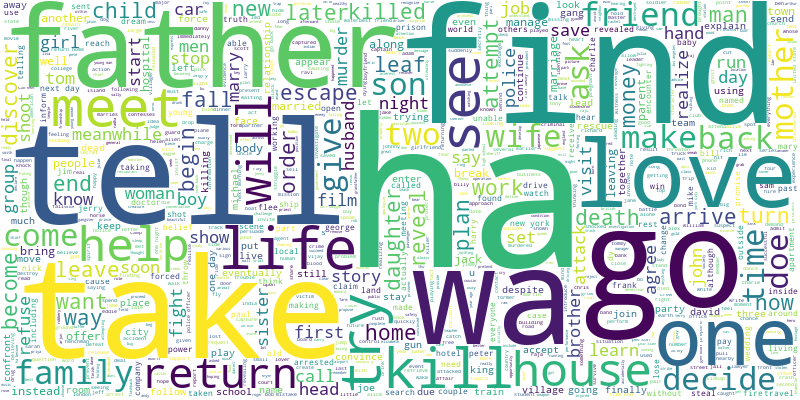

In [8]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


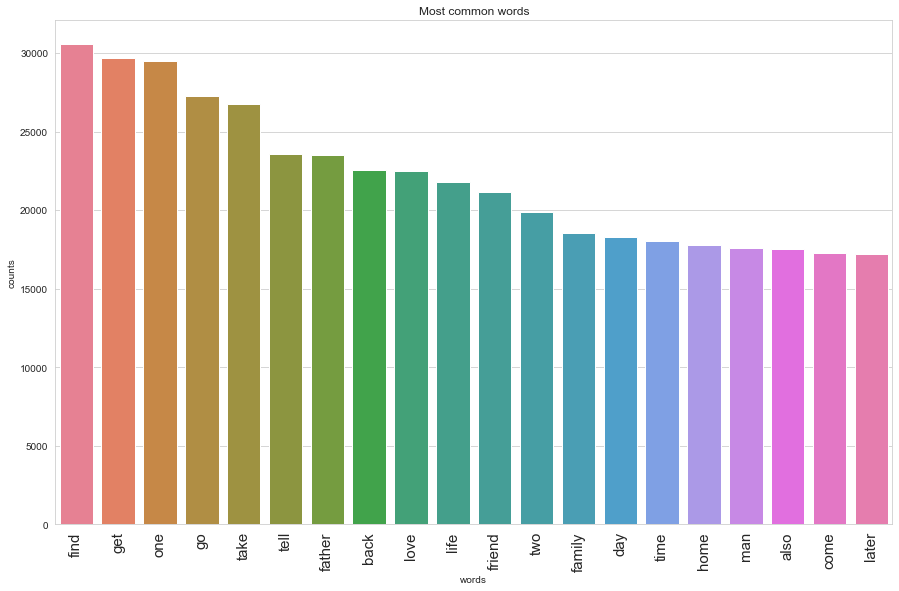

In [13]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [14]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [20]:
lda = LatentDirichletAllocation(n_components=5)
X_new = lda.fit_transform(count_data)

In [30]:
X_new.shape

(34886, 5)

In [32]:
print_topics(count_vectorizer, X_new.T, 5)


Topic #0


IndexError: list index out of range

**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

In [ ]:
### YOUR CODE HERE

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\;\Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

In [ ]:
### YOUR FORMULAS HERE

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [ ]:
class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
    
    def _initialize(self, bow):
        V = bow.shape[1]
        self.mu = None
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        ### YOUR CODE HERE ###
        
    def _m_step(self, bow):
        ### YOUR CODE HERE ###
        
    def _count_elbo(self, bow):
        elbo = ### YOUR CODE HERE ###
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

In [ ]:
### YOUR CODE HERE ###


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

In [ ]:
### YOUR CODE HERE ###